In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import metrics

In [3]:
df = pd.read_csv("/content/BTC-USD.csv", parse_dates=['Date'], index_col='Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,10198.599609,11046.700195,9694.650391,10975.599609,10975.599609,6783119872
2017-12-02,10978.299805,11320.200195,10905.099609,11074.599609,11074.599609,5138500096
2017-12-03,11082.700195,11858.700195,10862.000000,11323.200195,11323.200195,6608309760
2017-12-04,11315.400391,11657.200195,11081.799805,11657.200195,11657.200195,6132409856
2017-12-05,11685.700195,12032.000000,11604.599609,11916.700195,11916.700195,6895260160


# Mô tả dữ liệu

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1941 entries, 2018-01-01 to 2023-04-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1941 non-null   float64
 1   High       1941 non-null   float64
 2   Low        1941 non-null   float64
 3   Close      1941 non-null   float64
 4   Adj Close  1941 non-null   float64
 5   Volume     1941 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 106.1 KB


In [ ]:
# Số hàng và số cột trong df
df.shape

(1941, 6)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,1941.0,1.177315e+03,1.171805e+03,8.427969e+01,2.142301e+02,6.085228e+02,1.794922e+03,4.810071e+03
High,1941.0,1.213744e+03,1.207323e+03,8.534274e+01,2.202364e+02,6.218880e+02,1.839497e+03,4.891705e+03
Low,1941.0,1.136277e+03,1.131094e+03,8.282989e+01,2.086924e+02,5.844117e+02,1.736706e+03,4.718039e+03
Close,1941.0,1.177644e+03,1.171395e+03,8.430830e+01,2.142191e+02,6.084540e+02,1.799166e+03,4.812087e+03
Adj Close,1941.0,1.177644e+03,1.171395e+03,8.430830e+01,2.142191e+02,6.084540e+02,1.799166e+03,4.812087e+03
Volume,1941.0,1.293776e+10,1.053580e+10,9.484880e+08,5.485191e+09,1.052497e+10,1.798094e+10,8.448291e+10


In [ ]:
# Kiểm tra xem có bao nhiêu dòng dữ liệu trong tất cả các cột có giá trị là null
df.isnull().sum().sort_values(ascending = False)

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
# Loại bỏ các trường không cần thiết
df = df.drop(columns = ['Adj Close'])
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-12-01,10198.599609,11046.700195,9694.650391,10975.599609,6783119872
2017-12-02,10978.299805,11320.200195,10905.099609,11074.599609,5138500096
2017-12-03,11082.700195,11858.700195,10862.000000,11323.200195,6608309760
2017-12-04,11315.400391,11657.200195,11081.799805,11657.200195,6132409856
2017-12-05,11685.700195,12032.000000,11604.599609,11916.700195,6895260160


# Áp dụng thuật toán XGBOOST
**I. Chuẩn bị dữ liệu**
1. Tách dữ liệu thành các tập x(đầu vào) và y(đầu ra)

In [5]:
#Tách tập dữ liệu
x = df[['Open','High','Low','Volume']]
y = df['Close']

In [ ]:
x.head()

,Open,High,Low,Volume
Date,,,,
2018-01-01,14112.2002,14112.20020,13154.70020,1.029120e+10
2018-01-02,13625.0000,15444.59961,13163.59961,1.684660e+10
2018-01-03,14978.2002,15572.79981,14844.50000,1.687190e+10
2018-01-04,15270.7002,15739.70020,14522.20020,2.178320e+10
2018-01-05,15477.2002,17705.19922,15202.79981,2.384090e+10


In [ ]:
y.head()

Date
2018-01-01    772.640991
2018-01-02    884.443970
2018-01-03    962.719971
2018-01-04    980.921997
2018-01-05    997.719971
Name: Close, dtype: float64

**II. Cắt dữ liệu thành các tập train, test và validate**

In [16]:
n_rows = len(df)
train_rows = int(n_rows * 0.5)
test_rows = int(n_rows * 0.3)
val_rows = n_rows - train_rows - test_rows

# Chia tập dữ liệu thành 3 tập train, test và validate
X_train = x[:train_rows]
X_test = x[train_rows:train_rows+test_rows]
X_validate = x[train_rows+test_rows:]

Y_train = y[:train_rows]
Y_test = y[train_rows:train_rows+test_rows]
Y_validate = y[train_rows+test_rows:]

In [ ]:
X_train.head()

,Open,High,Low,Volume
Date,,,,
2018-01-01,755.757019,782.530029,742.004028,2595760128
2018-01-02,772.346008,914.830017,772.346008,5783349760
2018-01-03,886.000000,974.471008,868.450989,5093159936
2018-01-04,961.713013,1045.079956,946.085999,6502859776
2018-01-05,975.750000,1075.390015,956.325012,6683149824


In [ ]:
Y_train.head()

Date
2018-01-01    772.640991
2018-01-02    884.443970
2018-01-03    962.719971
2018-01-04    980.921997
2018-01-05    997.719971
Name: Close, dtype: float64

In [17]:
from xgboost import XGBRegressor

# Khởi tạo mô hình XGBoost hồi quy
model = XGBRegressor(objective='reg:squarederror', #đặt mục tiêu của mô hình là hồi quy và sử dụng square error loss để đánh giá sự khác biệt giữa gtri dự đoán và thực tế
    eval_metric='rmse', #tham số xác định độ đo để đánh giá hiệu suất của mô hình
    learning_rate=0.1, #tỷ lệ học của mô hình
    max_depth=3, #độ sâu tối đa của cây
    n_estimators=100 #số lượng cây
    )

# Huấn luyện mô hình trên dữ liệu huấn luyện
model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [18]:
# Dự đoán giá Close
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_validate)

**Đánh giá mô hình trên tập test tỉ lệ 5:3:2**

In [19]:
# Đánh giá mô hình trên tập test

# 1. mse:tổng bình phương sai số trên tập mẫu (Giá trị MSE càng nhỏ, mô hình dự báo càng chính xác.)
mse = metrics.mean_squared_error(Y_test,y_pred)

# 2. rmse: căn của tổng bình phương sai số trên tập mẫu,được sử dụng để đánh giá sai số trung bình giữa giá trị dự báo và giá trị thực tế
#(giá trị này càng nhỏ thì mô hình càng chính xác)
rmse = np.sqrt(mse)

# 3. mae : trị tuyệt đối trung bình(giá trị này càng nhỏ thì mô hình càng chính xác)
mae = metrics.mean_absolute_error(Y_test,y_pred)

#4. mape : tính toán độ sai lệch trung bình giữa các giá trị dự đoán và giá trị thực tế dưới dạng phần trăm(Giá trị MAPE càng nhỏ thì độ chính xác của mô hình càng cao)
#  mô hình có MAPE dưới 10% được xem là rất tốt
mape = metrics.mean_absolute_percentage_error(Y_test,y_pred)

# 5.r2_score(): đánh giá xem mô hình có phù hợp và tốt hay không, trả về giá trị nằm trong khoảng từ 0 đến 1,
# với giá trị 0 có nghĩa là không có mối quan hệ, với giá trị là 1 có nghĩa là mô hình phù hợp và tốt 100%.
r2 = r2_score(Y_test,y_pred)

print('MSE: ' , mse)
print('RMSE: ' , rmse)
print('MAE: ' , mae)
print('MAPE: ', mape * 100)
print('R2_squared: ' , r2)

MSE:  668603282.4535406
RMSE:  25857.364182250683
MAE:  22293.199584657898
MAPE:  47.91125107976586
R2_squared:  -2.1554865681469995


**Đánh giá mô hình trên tập test tỉ lệ 6:2:2**

In [14]:
# Đánh giá mô hình trên tập test

# 1. mse:tổng bình phương sai số trên tập mẫu (Giá trị MSE càng nhỏ, mô hình dự báo càng chính xác.)
mse = metrics.mean_squared_error(Y_test,y_pred)

# 2. rmse: căn của tổng bình phương sai số trên tập mẫu,được sử dụng để đánh giá sai số trung bình giữa giá trị dự báo và giá trị thực tế
#(giá trị này càng nhỏ thì mô hình càng chính xác)
rmse = np.sqrt(mse)

# 3. mae : trị tuyệt đối trung bình(giá trị này càng nhỏ thì mô hình càng chính xác)
mae = metrics.mean_absolute_error(Y_test,y_pred)

#4. mape : tính toán độ sai lệch trung bình giữa các giá trị dự đoán và giá trị thực tế dưới dạng phần trăm(Giá trị MAPE càng nhỏ thì độ chính xác của mô hình càng cao)
#  mô hình có MAPE dưới 10% được xem là rất tốt
mape = metrics.mean_absolute_percentage_error(Y_test,y_pred)

# 5.r2_score(): đánh giá xem mô hình có phù hợp và tốt hay không, trả về giá trị nằm trong khoảng từ 0 đến 1,
# với giá trị 0 có nghĩa là không có mối quan hệ, với giá trị là 1 có nghĩa là mô hình phù hợp và tốt 100%.
r2 = r2_score(Y_test,y_pred)

print('MSE: ' , mse)
print('RMSE: ' , rmse)
print('MAE: ' , mae)
print('MAPE: ', mape * 100)
print('R2_squared: ' , r2)

MSE:  2794178.7255889922
RMSE:  1671.579709612734
MAE:  1256.2282691141706
MAPE:  2.6468624592272634
R2_squared:  0.964638609911649


**Đánh giá mô hình trên tập validate tỉ lệ 6:2:2**

In [15]:
# Đánh giá mô hình trên tập validate

# 1. mse:tổng bình phương sai số trên tập mẫu (Giá trị MSE càng nhỏ, mô hình dự báo càng chính xác.)
mse = metrics.mean_squared_error(Y_validate,y_pred_val)

# 2. rmse: căn của tổng bình phương sai số trên tập mẫu,được sử dụng để đánh giá sai số trung bình giữa giá trị dự báo và giá trị thực tế
#(giá trị này càng nhỏ thì mô hình càng chính xác)
rmse = np.sqrt(mse)

# 3. mae : trị tuyệt đối trung bình(giá trị này càng nhỏ thì mô hình càng chính xác)
mae = metrics.mean_absolute_error(Y_validate,y_pred_val)

#4. mape : tính toán độ sai lệch trung bình giữa các giá trị dự đoán và giá trị thực tế dưới dạng phần trăm(Giá trị MAPE càng nhỏ thì độ chính xác của mô hình càng cao)
#  mô hình có MAPE dưới 10% được xem là rất tốt
mape = metrics.mean_absolute_percentage_error(Y_validate,y_pred_val)

# 5.r2_score(): đánh giá xem mô hình có phù hợp và tốt hay không, trả về giá trị nằm trong khoảng từ 0 đến 1,
# với giá trị 0 có nghĩa là không có mối quan hệ, với giá trị là 1 có nghĩa là mô hình phù hợp và tốt 100%.
r2 = r2_score(Y_validate,y_pred_val)

print('MSE: ' , mse)
print('RMSE: ' , rmse)
print('MAE: ' , mae)
print('MAPE: ', mape * 100)
print('R2_squared: ' , r2)

MSE:  711486.5927750603
RMSE:  843.4966465701333
MAE:  629.9116932332203
MAPE:  2.692478409653647
R2_squared:  0.9636436577274833


**Đánh giá mô hình trên tập test tỉ lệ 7:2:1**

In [9]:
# Đánh giá mô hình trên tập test

# 1. mse:tổng bình phương sai số trên tập mẫu (Giá trị MSE càng nhỏ, mô hình dự báo càng chính xác.)
mse = metrics.mean_squared_error(Y_test,y_pred)

# 2. rmse: căn của tổng bình phương sai số trên tập mẫu,được sử dụng để đánh giá sai số trung bình giữa giá trị dự báo và giá trị thực tế
#(giá trị này càng nhỏ thì mô hình càng chính xác)
rmse = np.sqrt(mse)

# 3. mae : trị tuyệt đối trung bình(giá trị này càng nhỏ thì mô hình càng chính xác)
mae = metrics.mean_absolute_error(Y_test,y_pred)

#4. mape : tính toán độ sai lệch trung bình giữa các giá trị dự đoán và giá trị thực tế dưới dạng phần trăm(Giá trị MAPE càng nhỏ thì độ chính xác của mô hình càng cao)
#  mô hình có MAPE dưới 10% được xem là rất tốt
mape = metrics.mean_absolute_percentage_error(Y_test,y_pred)

# 5.r2_score(): đánh giá xem mô hình có phù hợp và tốt hay không, trả về giá trị nằm trong khoảng từ 0 đến 1,
# với giá trị 0 có nghĩa là không có mối quan hệ, với giá trị là 1 có nghĩa là mô hình phù hợp và tốt 100%.
r2 = r2_score(Y_test,y_pred)

print('MSE: ' , mse)
print('RMSE: ' , rmse)
print('MAE: ' , mae)
print('MAPE: ', mape * 100)
print('R2_squared: ' , r2)

MSE:  1156251.9303552401
RMSE:  1075.291555976908
MAE:  807.3902720693069
MAPE:  2.6342940953357217
R2_squared:  0.9941569963796533


**Đánh giá mô hình trên tập validate tỉ lệ 7:2:1**

In [10]:
# Đánh giá mô hình trên tập validate

# 1. mse:tổng bình phương sai số trên tập mẫu (Giá trị MSE càng nhỏ, mô hình dự báo càng chính xác.)
mse = metrics.mean_squared_error(Y_validate,y_pred_val)

# 2. rmse: căn của tổng bình phương sai số trên tập mẫu,được sử dụng để đánh giá sai số trung bình giữa giá trị dự báo và giá trị thực tế
#(giá trị này càng nhỏ thì mô hình càng chính xác)
rmse = np.sqrt(mse)

# 3. mae : trị tuyệt đối trung bình(giá trị này càng nhỏ thì mô hình càng chính xác)
mae = metrics.mean_absolute_error(Y_validate,y_pred_val)

#4. mape : tính toán độ sai lệch trung bình giữa các giá trị dự đoán và giá trị thực tế dưới dạng phần trăm(Giá trị MAPE càng nhỏ thì độ chính xác của mô hình càng cao)
#  mô hình có MAPE dưới 10% được xem là rất tốt
mape = metrics.mean_absolute_percentage_error(Y_validate,y_pred_val)

# 5.r2_score(): đánh giá xem mô hình có phù hợp và tốt hay không, trả về giá trị nằm trong khoảng từ 0 đến 1,
# với giá trị 0 có nghĩa là không có mối quan hệ, với giá trị là 1 có nghĩa là mô hình phù hợp và tốt 100%.
r2 = r2_score(Y_validate,y_pred_val)

print('MSE: ' , mse)
print('RMSE: ' , rmse)
print('MAE: ' , mae)
print('MAPE: ', mape * 100)
print('R2_squared: ' , r2)

MSE:  661501.5472698763
RMSE:  813.3274539014875
MAE:  600.805346541564
MAPE:  2.5030490345891816
R2_squared:  0.966754004700644


**Chênh lệch giữa giá Close thực tế và giá Close dự đoán**

In [ ]:
diff = np.abs(Y_test - y_pred)
new = pd.DataFrame({'Close thực tế' : Y_test,
                    'Close dự đoán' : y_pred,
                    'Độ lệch': diff})
new.head()

,Close thực tế,Close dự đoán,Độ lệch
Date,,,
2021-09-20,42843.80078,45861.523438,3017.722658
2021-09-21,40693.67578,41607.125000,913.449220
2021-09-22,43574.50781,41607.125000,1967.382810
2021-09-23,44895.09766,43663.183594,1231.914066
2021-09-24,42839.75000,43737.972656,898.222656


**Dự đoán giá Close trong 30 ngày tiếp theo**

In [ ]:
x_future = X_validate[:30]  # Dữ liệu x của 30 ngày tiếp theo
y_future_pred = model.predict(x_future)
#print("Dự đoán giá Close trong 30 ngày tiếp theo:", y_future_pred)

print("Dự đoán giá Close 30 ngày tiếp theo:")
for i in range(30):
  print(f"Ngày {i+1}: {y_future_pred[i]}")

Dự đoán giá Close 30 ngày tiếp theo:
Ngày 1: 18985.4453125
Ngày 2: 19447.1796875
Ngày 3: 18919.66796875
Ngày 4: 19339.4140625
Ngày 5: 19438.046875
Ngày 6: 19438.046875
Ngày 7: 19339.4140625
Ngày 8: 19185.013671875
Ngày 9: 18829.052734375
Ngày 10: 19074.068359375
Ngày 11: 19438.046875
Ngày 12: 19438.046875
Ngày 13: 19447.1796875
Ngày 14: 21237.630859375
Ngày 15: 22722.208984375
Ngày 16: 21180.5
Ngày 17: 22722.208984375
Ngày 18: 22713.076171875
Ngày 19: 22722.208984375
Ngày 20: 20988.88671875
Ngày 21: 22678.09375
Ngày 22: 19447.1796875
Ngày 23: 21237.630859375
Ngày 24: 22722.208984375
Ngày 25: 22738.734375
Ngày 26: 22747.015625
Ngày 27: 22085.15234375
Ngày 28: 17402.373046875
Ngày 29: 17414.96875
Ngày 30: 17570.126953125


**Vẽ đồ thị so sánh giá trị thực tế và giá trị dự đoán trên tập TEST và Validate tỉ lệ 6:2:2**




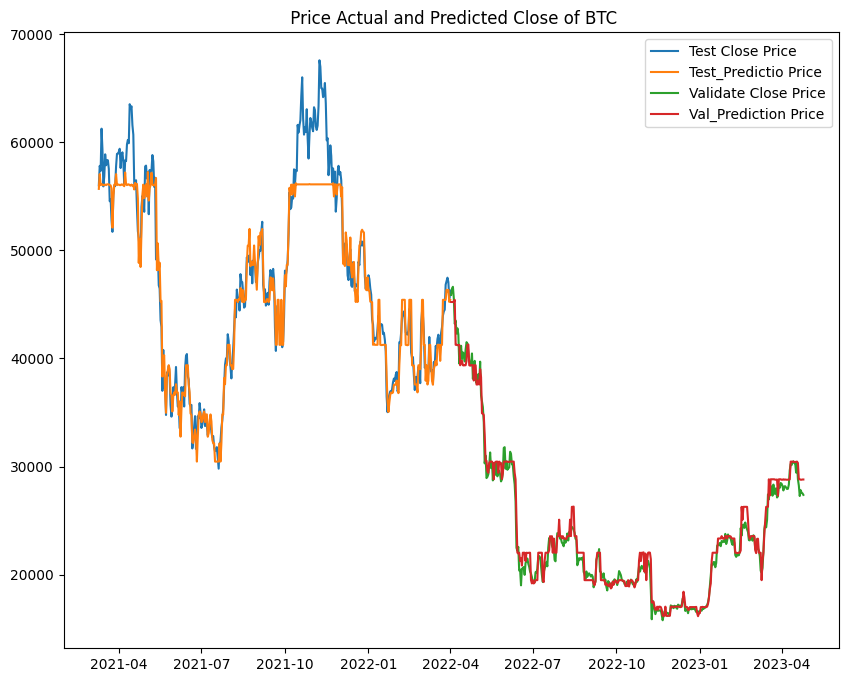

In [ ]:

plt.figure(figsize=(10, 8))
plt.title(' Price Actual and Predicted Close of BTC')
plt.plot(X_test.index,Y_test, label='Test Close Price')
plt.plot(X_test.index,y_pred, label='Test_Predictio Price')
plt.plot(X_validate.index,Y_validate, label='Validate Close Price')
plt.plot(X_validate.index,y_pred_val, label='Val_Prediction Price')
plt.legend()
plt.show()

**Vẽ đồ thị so sánh giá trị thực tế và giá trị dự đoán trên tập TEST và Validate tỉ lệ 7:2:1**




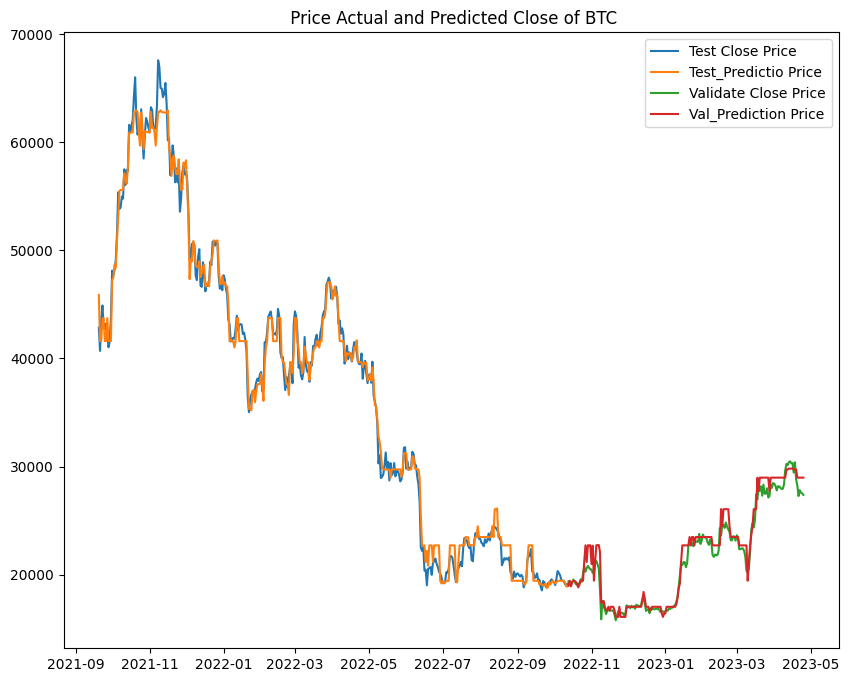

In [ ]:

plt.figure(figsize=(10, 8))
plt.title(' Price Actual and Predicted Close of BTC')
plt.plot(X_test.index,Y_test, label='Test Close Price')
plt.plot(X_test.index,y_pred, label='Test_Predictio Price')
plt.plot(X_validate.index,Y_validate, label='Validate Close Price')
plt.plot(X_validate.index,y_pred_val, label='Val_Prediction Price')
plt.legend()
plt.show()

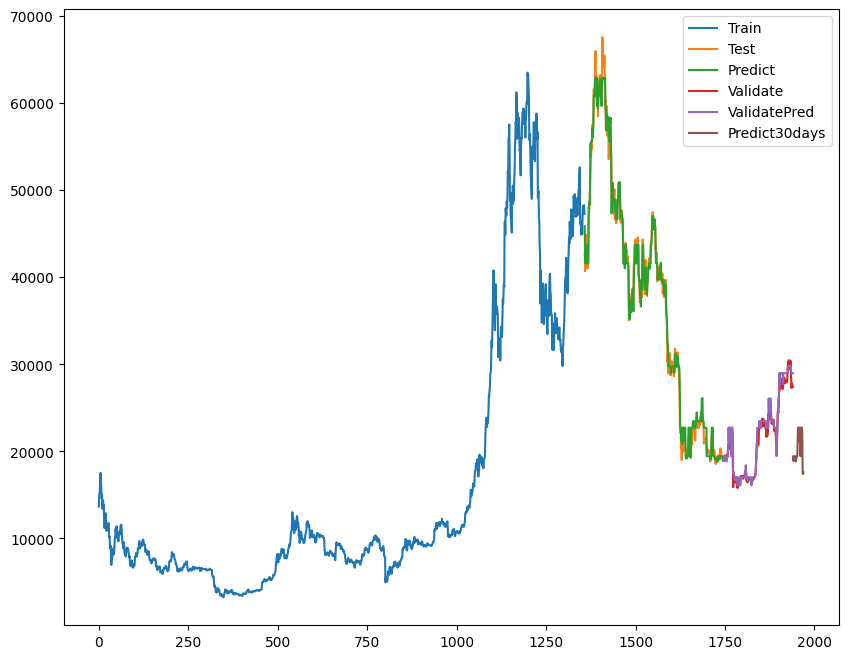

In [ ]:
# Vẽ hình
plt.figure(figsize=(10,8))
train_data_index = pd.RangeIndex(start=0, stop=train_rows, step=1)
plt.plot(train_data_index, Y_train)
test_data_index = pd.RangeIndex(start=train_rows, stop=train_rows+test_rows)
plt.plot(test_data_index,Y_test)
test_data_index = pd.RangeIndex(start=train_rows, stop=train_rows+test_rows)
plt.plot(test_data_index,y_pred)
val_data_index = pd.RangeIndex(start=train_rows+test_rows, stop=train_rows+test_rows+val_rows)
plt.plot(val_data_index,Y_validate)
val_data_index = pd.RangeIndex(start=train_rows+test_rows, stop=train_rows+test_rows+val_rows)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index, y_future_pred)
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()